In [1]:
%matplotlib inline


Finetuning Torchvision Models
=============================

**Author:** `Nathan Inkawhich <https://github.com/inkawhich>`__




In this tutorial we will take a deeper look at how to finetune and
feature extract the `torchvision
models <https://pytorch.org/docs/stable/torchvision/models.html>`__, all
of which have been pretrained on the 1000-class Imagenet dataset. This
tutorial will give an indepth look at how to work with several modern
CNN architectures, and will build an intuition for finetuning any
PyTorch model. Since each model architecture is different, there is no
boilerplate finetuning code that will work in all scenarios. Rather, the
researcher must look at the existing architecture and make custom
adjustments for each model.

In this document we will perform two types of transfer learning:
finetuning and feature extraction. In **finetuning**, we start with a
pretrained model and update *all* of the model’s parameters for our new
task, in essence retraining the whole model. In **feature extraction**,
we start with a pretrained model and only update the final layer weights
from which we derive predictions. It is called feature extraction
because we use the pretrained CNN as a fixed feature-extractor, and only
change the output layer. For more technical information about transfer
learning see `here <https://cs231n.github.io/transfer-learning/>`__ and
`here <https://ruder.io/transfer-learning/>`__.

In general both transfer learning methods follow the same few steps:

-  Initialize the pretrained model
-  Reshape the final layer(s) to have the same number of outputs as the
   number of classes in the new dataset
-  Define for the optimization algorithm which parameters we want to
   update during training
-  Run the training step




In [1]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import numpy as np
from numpy.linalg import eig, inv
import numpy as np
import numpy.linalg as linalg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

PyTorch Version:  1.7.0
Torchvision Version:  0.8.0a0


In [2]:
if torch.cuda.device_count()>1:
    device = torch.device('cuda:2')
elif torch.cuda.device_count()==1:
    device = torch.device('cuda')
else: 
    device = torch.device('cpu')
print(device)

cuda:2


Inputs
------

Here are all of the parameters to change for the run. We will use the
*hymenoptera_data* dataset which can be downloaded
`here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`__.
This dataset contains two classes, **bees** and **ants**, and is
structured such that we can use the
`ImageFolder <https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.ImageFolder>`__
dataset, rather than writing our own custom dataset. Download the data
and set the ``data_dir`` input to the root directory of the dataset. The
``model_name`` input is the name of the model you wish to use and must
be selected from this list:

::

   [resnet, alexnet, vgg, squeezenet, densenet, inception]

The other inputs are as follows: ``num_classes`` is the number of
classes in the dataset, ``batch_size`` is the batch size used for
training and may be adjusted according to the capability of your
machine, ``num_epochs`` is the number of training epochs we want to run,
and ``feature_extract`` is a boolean that defines if we are finetuning
or feature extracting. If ``feature_extract = False``, the model is
finetuned and all model parameters are updated. If
``feature_extract = True``, only the last layer parameters are updated,
the others remain fixed.




In [3]:
# mpl = [r'D:\seva\hymenoptera_data',  r'D:/data/hymenoptera_data'] 
# mpl = [s.replace('\\','/') for s in mpl]
# i = 0
# while not os.path.exists(mpl[i]):
#     print(i)
#     i+=1
# data_dir = mpl[i]
# print(data_dir)

In [4]:
depth = 2**8-1.
D_out = 441
C_in = 3 #how many views of one seed
mpl = [r'/home/cherepashkin/data/598_processing',  r'D:\data\seeds\598', r'D:\seva\598_processing'.replace('\\','/')] 
mpl = [s.replace('\\','/') for s in mpl]
i = 0
while not os.path.exists(mpl[i]):
    print(i)
    i+=1
data_dir = mpl[i]
print(data_dir)


0
1
2


IndexError: list index out of range

In [5]:
# Top level data directory. Here we assume the format of the directory conforms 
#   to the ImageFolder structure
#data_dir = D:\seva\hymenoptera_data
#    "D:/data/hymenoptera_data"
    #""./data/hymenoptera_data"
data_dir

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "alexnet"

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for 
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = True

#number of spherical harmonics amplituds to regress
ampl = 9

# Number of classes in the dataset
num_classes = ampl

#downsample ply, taking point every ds steps
ds = 10

NameError: name 'data_dir' is not defined

Helper Functions - train_model
----------------

Before we write the code for adjusting the models, lets define a few
helper functions.

Model Training and Validation Code
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

The ``train_model`` function handles the training and validation of a
given model. As input, it takes a PyTorch model, a dictionary of
dataloaders, a loss function, an optimizer, a specified number of epochs
to train and validate for, and a boolean flag for when the model is an
Inception model. The *is_inception* flag is used to accomodate the
*Inception v3* model, as that architecture uses an auxiliary output and
the overall model loss respects both the auxiliary output and the final
output, as described
`here <https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958>`__.
The function trains for the specified number of epochs and after each
epoch runs a full validation step. It also keeps track of the best
performing model (in terms of validation accuracy), and at the end of
training returns the best performing model. After each epoch, the
training and validation accuracies are printed.




In [6]:
#print(tmean[:,:ampl])

In [8]:
Y_N2 = np.genfromtxt('D:/seva/598test/Y_N_1001.csv', delimiter = ',', dtype = 'float32')

In [9]:
Y_N2.shape

(1000, 441)

In [10]:
mx = np.max(Y_N2)
mn = np.min(Y_N2)

In [11]:
print(mx,mn)

1.732093 -1.6961455


In [12]:
Y = (Y_N2-mn)/(mx-mn)

In [13]:
Y = torch.tensor(Y).to(device)
Y_N2 = torch.tensor(Y_N2).to(device)

In [14]:
Y.dtype

torch.float32

In [15]:
torch.min(Y)

tensor(0., device='cuda:0')

In [16]:
# weightv = torch.tensor([0.99, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]).to(device)
# def my_loss(output, target):
#     l = torch.mean(torch.multiply(weightv,(output - target))**2)
#     return l

In [17]:
#my_loss(torch.zeros([8,9]),torch.zeros([8,9]))

In [18]:
maxar.shape

NameError: name 'maxar' is not defined

In [19]:
F_2N_stat[1,:].shape

NameError: name 'F_2N_stat' is not defined

In [20]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    
#    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    lossar = np.zeros([2,num_epochs])
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            rloss = 0.0
            
            # Iterate over data.
            for i_batch, sample_batched in enumerate(dataloaders[phase]):
                if i_batch == bn:
                    break
                inputs = sample_batched['image']
                labels = sample_batched['landmarks']
#             for inputs, labels in dataloaders[phase]:
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
#                         output = torch.matmul(outputs,maxar-minar)+minar
#                         ff = torch.matmul(Y,torch.transpose(outputs,0,1))
#                         loss = criterion(torch.transpose(ff,0,1), inputs)
#                         outputs = torch.mul(outputs,torch.unsqueeze(maxar-minar, 0))+\
#                         torch.unsqueeze(minar,0)
                        ff = torch.matmul(Y_N2,torch.transpose(outputs,0,1))
#                         print(outputs.shape,maxar.shape)
#                         print()
#                         ff = torch.mul(ff,torch.unsqueeze(maxar-minar, 1))+torch.unsqueeze(minar,1)
                        loss = criterion(torch.transpose(ff,0,1), inputs)
#                         loss = criterion(outputs,labels)
#             torch.transpose(Y,0,1)
#                         loss = criterion(outputs,labels)
                        #loss = my_loss(outputs,labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                rloss += loss.item()
#                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            if phase == 'train':
                lossar[0][epoch] = rloss/bn
            else: 
                lossar[1][epoch] = rloss/bn            
#            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.6f}'.format(phase, rloss/bn))
#            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss,epoch_acc))

            # deep copy the model
#            if phase == 'val' and epoch_acc > best_acc:
#                best_acc = epoch_acc
#            best_model_wts = copy.deepcopy(model.state_dict())
#             if phase == 'val':
#                 val_acc_history.append(epoch_acc)
            val_acc_history = []

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
#    model.load_state_dict(best_model_wts)
    return model, lossar

Set Model Parameters’ .requires_grad attribute
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

This helper function sets the ``.requires_grad`` attribute of the
parameters in the model to False when we are feature extracting. By
default, when we load a pretrained model all of the parameters have
``.requires_grad=True``, which is fine if we are training from scratch
or finetuning. However, if we are feature extracting and only want to
compute gradients for the newly initialized layer then we want all of
the other parameters to not require gradients. This will make more sense
later.




In [21]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [22]:
1.5e5

150000.0

# Initialize and Reshape the Networks

In [23]:
class FCL(torch.nn.Module):
    def __init__(self,ampl):
        super().__init__()
        hn1 = int(1e4)
        hn2 = int(1e4)
        hn3 = int(1e4)
        self.linear1 = torch.nn.Linear(1000, hn1)
        self.linear2 = torch.nn.Linear(hn1, hn2)
        self.linear3 = torch.nn.Linear(hn2, hn3)
        self.linear4 = torch.nn.Linear(hn3, ampl)
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        x = self.linear4(x)
        return x

In [24]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224

    elif model_name == "inception":
        """ Inception v3 
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size



In [25]:
tmean = np.genfromtxt("tmean.csv", delimiter=',')

Load Data
---------

Now that we know what the input size must be, we can initialize the data
transforms, image datasets, and the dataloaders. Notice, the models were
pretrained with the hard-coded normalization values, as described
`here <https://pytorch.org/docs/master/torchvision/models.html>`__.




In [26]:
class Seed3D_Dataset(Dataset):
    """seed point cloud dataset."""

    def __init__(self, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(os.path.join(root_dir,'F_N_1001.csv'))
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
#        img = np.zeros([40000, 3, 1])
        rd = self.root_dir.replace('598test','598_processing')
#        rd = self.root_dir
        img_name = \
        os.path.join(rd,\
                     self.landmarks_frame.iloc[idx, 0]+'_Far_1001.csv').replace('\\','/')
        img = np.genfromtxt(img_name, delimiter = ',')
#        print(img_name)
#        img = np.concatenate((img, np.zeros([58014-img.shape[0]])), axis=0)
#         print(img.shape)
        #landmarks =  getelcoef(img) 
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        #landmarks = landmarks.astype('float').reshape(-1, D_out)
        landmarks = landmarks.astype('float')
        sample = {'image': img, 'landmarks': landmarks}
        if self.transform:
            sample = self.transform(sample)
        return sample

In [27]:
mins = [29.0, 1.0, 4.0]
mins[0]

29.0

In [22]:
#pwd

In [23]:
#print(data_dir,os.path.join(data_dir,'/sh_paramters.csv'))

In [24]:
#print(os.path.isfile('tmean.csv'),os.path.isfile(os.path.join(data_dir,'/sh_paramters.csv')))
#print(not(os.path.isfile('tmean.csv') and os.path.isfile(mainpath+'/sh_paramters.csv')))

In [28]:
class AmpCrop(object):
    """Crop the label, spherical harmonics amplitude."""
    def __init__(self, ampl):
        self.ampl = ampl
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        return {'image': image,
                'landmarks': landmarks[:,:self.ampl]}
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __init__(self, device):
#        assert isinstance(device, str)
        self.device = device
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        landmarks = np.squeeze(landmarks)
        return {'image': torch.Tensor(image).to(self.device),
                'landmarks': torch.Tensor(landmarks).to(self.device)}
class Minmax3Dimage(object):
    """Normalize 3D input data to be laying in [0,1]"""
    def __init__(self,minmax):
        self.minmax = minmax
#         minf = minmax[0]
#         maxf = minmax[1]
#         self.minf = minf
#         self.maxf = maxf
#        assert isinstance(device, str)
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
#         mins = [29.0, 1.0, 4.0]
#         maxs = [240., 116., 243.]
#         for i in range(3):
#             image[:,i] = (image[:,i]-mins[i])/\
#             (maxs[i]-mins[i])
#         minf = 0.60117054538415
#         maxf = 110.972068294924
#         image = (image-self.minf)/(self.maxf-self.minf)
        image = (image - self.minmax[2])/(self.minmax[3]-self.minmax[2])
#        print(image.shape)
#        landmarks = np.squeeze(landmarks)
        return {'image': image,
                'landmarks': landmarks}
class Downsample(object):
    """Downsample the input ply file."""
    def __init__(self, ds):
        #assert isinstance(output_size, (int, tuple))
        self.ds = ds
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        ds_image = image[::self.ds,:]
        return {'image': ds_image,
                'landmarks': landmarks}
class Shuffleinput(object):
    """Shuffle the rows of input ply file."""
    def __init__(self, shuffle_seed):
        #assert isinstance(output_size, (int, tuple))
        self.shuffle_seed = shuffle_seed
    def __call__(self, sample):
        np.random.seed(self.shuffle_seed)
        image, landmarks = sample['image'], sample['landmarks']
        np.random.shuffle(image) 
        return {'image': image,
                'landmarks': landmarks}
class Minmax(object):
    """Normalize the input data to lay in [0,1]."""
    def __init__(self, tmean):
#        assert isinstance(tmean, numpy.ndarraself.tmean = tmean
        self.tmean = tmean
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
#        print(type(landmarks))
#        print(type(self.tmean[3]))
        landmarks = (landmarks - self.tmean[2])/(self.tmean[3]-self.tmean[2])
#         minar = np.array([-0.000137326, -0.000210213, -0.000158576, -5.0600000000000003e-05,\
#        -3.02e-05, -5.03e-05, -0.001162729, -0.007046136999999999,\
#        -0.001537516])
#         maxar = np.array([-6.28e-06, -1.62e-05, -5.35e-06, 7.730000000000001e-05,\
#        0.000183897, 0.000125373, 0.018726644, 0.016954233, 0.018678133])
#         landmarks = (landmarks - minar)/(maxar-minar)
        
        return {'image': image,
                'landmarks': landmarks}
class Reshape(object):
    """Normalize the input data to lay in [0,1]."""
    def __init__(self, input_layer):
#        assert isinstance(tmean, numpy.ndarray)
        self.input_layer = input_layer
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
#        print(type(landmarks))
#        print(type(self.tmean[3]))
        padval = self.input_layer**2-image.shape[0]
        if padval >= 0:
            image = np.pad(image, ((0,padval),(0,0)), mode='constant')
        else: 
            image = image[:self.input_layer**2]
        image = np.reshape(image, [3,self.input_layer,self.input_layer])
#        landmarks = (landmarks - self.tmean[2])/(self.tmean[3]-self.tmean[2]) 
        return {'image': image,
                'landmarks': landmarks}


In [26]:
np.zeros(5)+np.min(tmean[2])

array([-11610.34032578, -11610.34032578, -11610.34032578, -11610.34032578,
       -11610.34032578])

In [27]:
# a=np.zeros([50000,3])
# a = np.pad(a, ((0,229**2-50000),(0,0)), mode='constant')
# a = np.reshape(a, [229,229,3])
# print(a.shape)
# #a.reshape([])


In [28]:
pwd

'C:\\Users\\v.cherepashkin\\Documents\\GitHub\\circles'

In [29]:
Far_stat = np.genfromtxt("D:/seva/598test/Far_1000_stat.csv", delimiter=',', dtype = 'float32')
F_2N_stat = np.genfromtxt("D:/seva/598test/F_N_1000_stat.csv", delimiter=',',dtype = 'float32')

In [30]:
maxar = torch.tensor(Far_stat[1,:]).to(device)
minar = torch.tensor(Far_stat[0,:]).to(device)

In [31]:
maxar = torch.tensor(F_2N_stat[1,:]).to(device)
minar = torch.tensor(F_2N_stat[0,:]).to(device)

In [29]:
batch_size = 8
ampl = 441
data_dir = 'D:/seva/598test/'
#         minf = 0.60117054538415
#         maxf = 110.972068294924
data_transforms = {
    'train': transforms.Compose([\
#            AmpCrop(ampl),\
#             Minmax(F_2N_stat),\
#             Minmax3Dimage(Far_stat),\
#            Downsample(ds),\
#           Shuffleinput(0),\
#             Reshape(224),\
#            Normalize(),\
            ToTensor(device)
    ]),
    'val': transforms.Compose([\
#            AmpCrop(ampl),\
#             Minmax(F_2N_stat),\
#             Minmax3Dimage(Far_stat),\
#            Downsample(ds),\
#           Shuffleinput(0),\
#             Reshape(224),\
#            Normalize(),\
            ToTensor(device)
    ]),
}
print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: Seed3D_Dataset(root_dir=os.path.join(data_dir,x), \
                                    transform=data_transforms[x]) 
                  for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=False, num_workers=0) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# dataset = Seed3D_Dataset(csv_file=mainpath+'/sh_paramters.csv', root_dir=data_dir, transform=data_transform)
# dataloader = DataLoader(dataset, bs,
#                         shuffle=False, num_workers=0)

Initializing Datasets and Dataloaders...


In [30]:
# phase = 'train'
# bn = 100
# for i_batch, sample_batched in enumerate(dataloaders_dict[phase]):
#     print(i_batch)
#     if i_batch == bn:
#         break
#     inputs = sample_batched['image']
#     labels = sample_batched['landmarks']

Create the Optimizer
--------------------

Now that the model structure is correct, the final step for finetuning
and feature extracting is to create an optimizer that only updates the
desired parameters. Recall that after loading the pretrained model, but
before reshaping, if ``feature_extract=True`` we manually set all of the
parameter’s ``.requires_grad`` attributes to False. Then the
reinitialized layer’s parameters have ``.requires_grad=True`` by
default. So now we know that *all parameters that have
.requires_grad=True should be optimized.* Next, we make a list of such
parameters and input this list to the SGD algorithm constructor.

To verify this, check out the printed parameters to learn. When
finetuning, this list should be long and include all of the model
parameters. However, when feature extracting this list should be short
and only include the weights and biases of the reshaped layers.




In [31]:
# # Send the model to GPU
# model_ft = model_ft.to(device)

# # Gather the parameters to be optimized/updated in this run. If we are
# #  finetuning we will be updating all parameters. However, if we are 
# #  doing feature extract method, we will only update the parameters
# #  that we have just initialized, i.e. the parameters with requires_grad
# #  is True.
# params_to_update = model_ft.parameters()
# print("Params to learn:")
# if feature_extract:
#     params_to_update = []
#     for name,param in model_ft.named_parameters():
#         if param.requires_grad == True:
#             params_to_update.append(param)
#             print("\t",name)
# else:
#     for name,param in model_ft.named_parameters():
#         if param.requires_grad == True:
#             print("\t",name)

# # Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Run Training and Validation Step
--------------------------------

Finally, the last step is to setup the loss for the model, then run the
training and validation function for the set number of epochs. Notice,
depending on the number of epochs this step may take a while on a CPU.
Also, the default learning rate is not optimal for all of the models, so
to achieve maximum accuracy it would be necessary to tune for each model
separately.




In [32]:
# Setup the loss fxn
#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss(reduction='mean')
bn = int(5e4)
num_epochs = 500
model_name = 'densenet'
lossar = np.zeros([2,num_epochs])
#scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
#for i,lr in enumerate([0.0001, 0.0005, 0.001, 0.005]):

ampl = 441
num_classes = ampl
#smodel, input_size = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
# Train and evaluate
smodel = FCL(ampl)
smodel.to(device)
scratch_optimizer = torch.optim.Adam(smodel.parameters(), \
            lr=5e-6, betas=(0.9, 0.999),\
            eps=1e-08, weight_decay=0, \
            amsgrad=False)
model, lossar = train_model(smodel, dataloaders_dict, criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/499
----------
train Loss: 0.220990
val Loss: 0.015224

Epoch 1/499
----------
train Loss: 0.035178
val Loss: 0.009426

Epoch 2/499
----------
train Loss: 0.024412
val Loss: 0.007749

Epoch 3/499
----------
train Loss: 0.019596
val Loss: 0.006700

Epoch 4/499
----------
train Loss: 0.016774
val Loss: 0.005976

Epoch 5/499
----------
train Loss: 0.014833
val Loss: 0.005473

Epoch 6/499
----------
train Loss: 0.013403
val Loss: 0.005058

Epoch 7/499
----------
train Loss: 0.012281
val Loss: 0.004705

Epoch 8/499
----------
train Loss: 0.011292
val Loss: 0.004326

Epoch 9/499
----------
train Loss: 0.010392
val Loss: 0.003899

Epoch 10/499
----------
train Loss: 0.009625
val Loss: 0.003540

Epoch 11/499
----------
train Loss: 0.009058
val Loss: 0.003360

Epoch 12/499
----------
train Loss: 0.008621
val Loss: 0.003161

Epoch 13/499
----------
train Loss: 0.008705
val Loss: 0.003396

Epoch 14/499
----------
train Loss: 0.008512
val Loss: 0.003328

Epoch 15/499
----------
train Loss:

In [ ]:
torch.mul(torch.randn(1250,64),torch.randn(1250))

<ipython-input-34-339f811aedda>:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axes.set_xticks(np.arange(0, int(num_epochs*1.1)),\


Text(0, 0.5, 'log10(MSE Loss)')

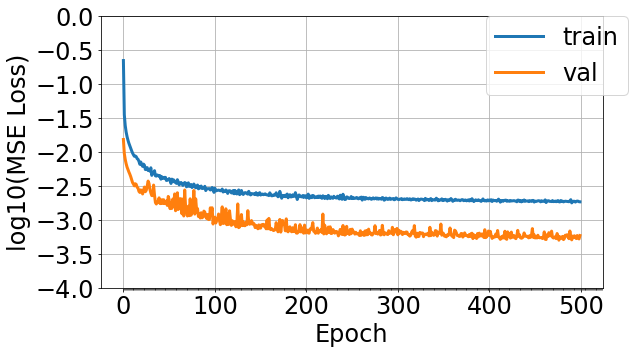

In [34]:
plt.rcParams["figure.figsize"] = (9,5)
fig = plt.figure()
axes = plt.gca()
ymin, ymax = -4, 2
axes.set_ylim([ymin,ymax])
labels_text = ['train', 'val']
for i in range(2):
    plt.plot(np.arange(lossar.shape[1]),np.log10(lossar[i,:]),label=labels_text[i],linewidth=3)
axes.set_xticks(np.arange(0, int(num_epochs*1.1)),\
                          max(int(num_epochs*0.1),1))
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc='best', borderaxespad=0., \
           fontsize = 24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.autoscale(enable=True, axis='both', tight=None)
# ymin, ymax = -, 2
# axes.set_ylim([ymin,ymax])
ymin, ymax = -4, 0
axes.set_ylim([ymin,ymax])
plt.xlabel('Epoch', fontsize=24)
plt.ylabel('log10(MSE Loss)', fontsize=24)

<ipython-input-36-64dfce7d997c>:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axes.set_xticks(np.arange(0, int(num_epochs*1.1)),\


Text(0, 0.5, 'log10(MSE Loss)')

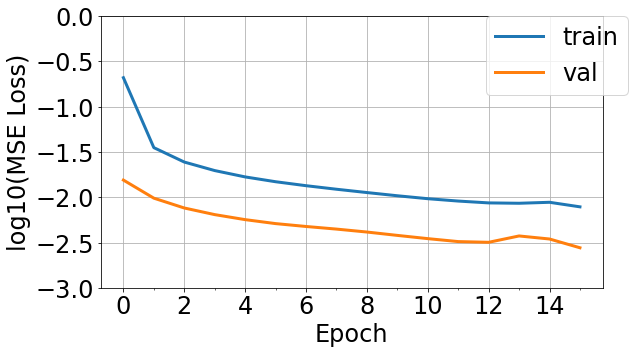

In [36]:
plt.rcParams["figure.figsize"] = (9,5)
fig = plt.figure()
axes = plt.gca()
ymin, ymax = -4, 2
axes.set_ylim([ymin,ymax])
labels_text = ['train', 'val']
for i in range(2):
    plt.plot(np.arange(lossar.shape[1]),np.log10(lossar[i,:]),label=labels_text[i],linewidth=3)
axes.set_xticks(np.arange(0, int(num_epochs*1.1)),\
                          max(int(num_epochs*0.1),1))
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc='best', borderaxespad=0., \
           fontsize = 24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.autoscale(enable=True, axis='both', tight=None)
ymin, ymax = -3, 0
axes.set_ylim([ymin,ymax])
plt.xlabel('Epoch', fontsize=24)
plt.ylabel('log10(MSE Loss)', fontsize=24)

## Return SH coefficient vector from the trained model

In [65]:
# print(tmean[:,:ampl].shape)

In [66]:
# minar = np.array([-0.000137326, -0.000210213, -0.000158576, -5.0600000000000003e-05,\
# -3.02e-05, -5.03e-05, -0.001162729, -0.007046136999999999,\
# -0.001537516])
# maxar = np.array([-6.28e-06, -1.62e-05, -5.35e-06, 7.730000000000001e-05,\
# 0.000183897, 0.000125373, 0.018726644, 0.016954233, 0.018678133])

In [72]:
maxar[0]

234.40142073837

In [36]:
phase = 'val'
bn = 1
ampl = 441
# minar = F_2N_stat[2,:ampl]
# maxar = F_2N_stat[3,:ampl]
#minar = Far_stat[2,:ampl]
#maxar = Far_stat[3,:ampl]
dataloaders = dataloaders_dict
for i_batch, sample_batched in enumerate(dataloaders[phase]):
    if i_batch == bn:
        break
    inputs = sample_batched['image']
    gt = sample_batched['landmarks']
    gtv = gt.detach().cpu().numpy()
#    print(model(inputs).shape)
    o = model(inputs).detach().cpu().numpy()
#     print(o.shape)
#     print(maxar.shape)
#    output = np.multiply(model(inputs).detach().cpu().numpy(),maxar-minar)+minar
#    real_output = np.multiply(gt.detach().cpu().numpy(),maxar-minar)+minar
#     opar = polyToParams3D(np.concatenate((output[0], [1])),True)
#     ropar = polyToParams3D(np.concatenate((real_output[0], [1])), True)

In [52]:
sum(o[0]-gtv[0])/441

-0.008392292482708738

In [37]:
# o[0]

In [38]:
np.savetxt('D:/seva/598test/F_N2output', o[0], delimiter = ',')

In [39]:
np.savetxt('D:/seva/598test/F_N2output', gtv[0], delimiter = ',')

## The worst case 

In [51]:
phase = 'val'
bn = 1e4
ampl = 441
minar = F_2N_stat[2,:ampl]
maxar = F_2N_stat[3,:ampl]
dataloaders = dataloaders_dict
mn = 100
for i_batch, sample_batched in enumerate(dataloaders[phase]):
    if i_batch == bn:
        break
    inputs = sample_batched['image']
    gt = sample_batched['landmarks']
#    print(model(inputs).shape)
    o = model(inputs)
    ff = torch.matmul(Y,torch.transpose(o,0,1))
#                         print(ff.shape,inputs.shape)
    loss = criterion(torch.transpose(ff,0,1), inputs)
    if loss.item()<mn:
        mn = loss.item()
#         mni = i_batch
        output = np.multiply(model(inputs).detach().cpu().numpy(),maxar-minar)+minar
#     print(o.shape)
#     print(maxar.shape)

#real_output = np.multiply(gt.detach().cpu().numpy(),maxar-minar)+minar
#     opar = polyToParams3D(np.concatenate((output[0], [1])),True)
#     ropar = polyToParams3D(np.concatenate((real_output[0], [1])), True)

In [52]:
np.savetxt('D:/seva/598test/F_N2output', real_output[0], delimiter = ',')

In [ ]:
# Setup the loss fxn
#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss(reduction='mean')
bn = 1000
num_epochs = 16
# model_name = 'densenet'
lrl = [5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3]
lossar = np.zeros([len(lrl),2,num_epochs])
#scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
for i,lr in enumerate(lrl):
#     scratch_model, input_size = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
    # Train and evaluate
    scratch_model=FCL(ampl)
    scratch_model.to(device)
    scratch_optimizer = torch.optim.Adam(scratch_model.parameters(), \
                lr, betas=(0.9, 0.999),\
                eps=1e-08, weight_decay=0, \
                amsgrad=False)
    model, lossar[i] = train_model(scratch_model, dataloaders_dict, criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

In [33]:
lrl = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2]
len(lrl)

7

In [202]:
lossar.shape

(2, 20)

<ipython-input-64-3d8bdd830c99>:11: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axes.set_xticks(np.arange(0, int(num_epochs*1.1)),\


NameError: name 'timel' is not defined

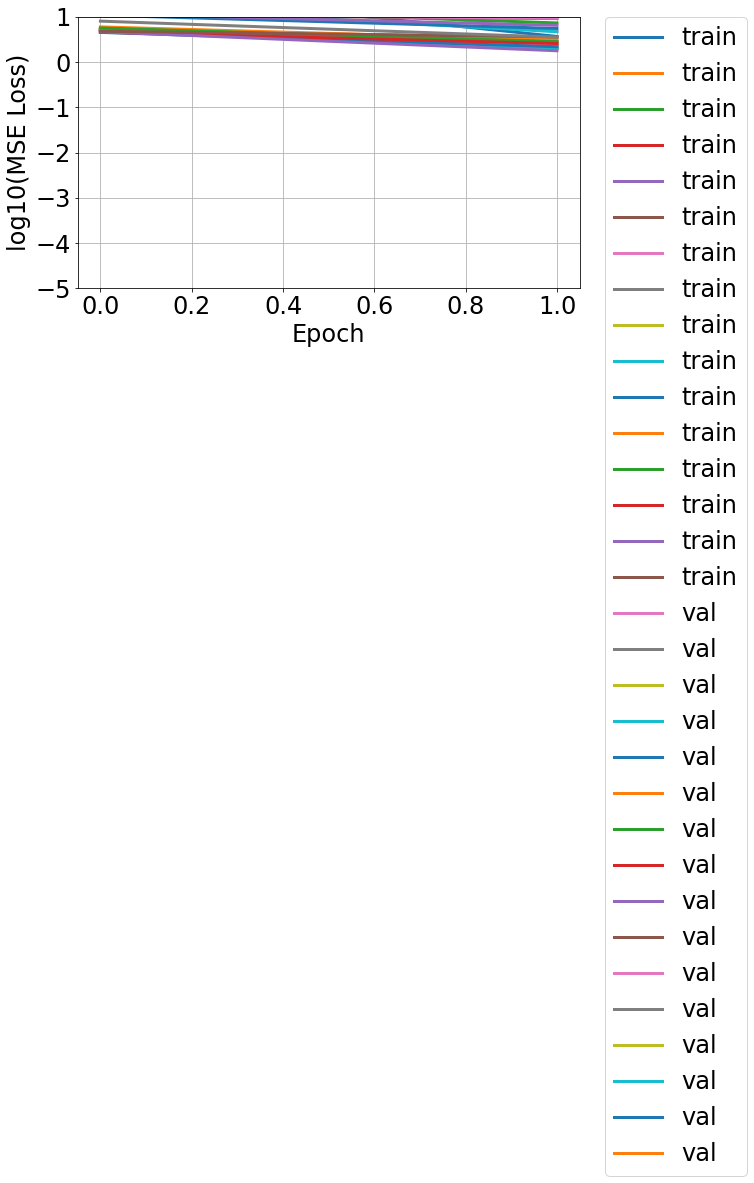

In [64]:
def traplot(lossar,ampl,bn,batch_size,num_epochs,lr):       
    plt.rcParams["figure.figsize"] = (9,5)
#     linestyles = ['-', '--', '-.', ':', '-', '--',\
#                   '-.', ':', '-', '--', '-.', ':']
#     colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
    fig = plt.figure()
    axes = plt.gca()
    labels_text = ['train', 'val']
    for i in range(2):
        plt.plot(np.arange(lossar.shape[1]),np.log10(lossar[i,:]),label=labels_text[i],linewidth=3)
    axes.set_xticks(np.arange(0, int(num_epochs*1.1)),\
                              max(int(num_epochs*0.1),1))
    plt.grid()
    plt.legend(bbox_to_anchor=(1.05, 1), loc='best', borderaxespad=0., \
               fontsize = 24)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.autoscale(enable=True, axis='both', tight=None)
    ymin, ymax = -5, 1
    axes.set_ylim([ymin,ymax])
    plt.xlabel('Epoch', fontsize=24)
    plt.ylabel('log10(MSE Loss)', fontsize=24)
    plt.savefig('plot output/'+\
                    'num_ampl='+str(ampl)+\
                    'bn'+str(bn)+\
                    'bs'+str(batch_size)+\
                    'epochs'+str(num_epochs)+\
                    'net_name=Densenet'+\
                    'lr'+str(lr)+\
                    'optimizer adam'+\
                    't'+timel+\
                '.png', bbox_inches='tight')
    plt.title('Learning curve \n', fontsize=24)
    plt.show()
traplot(lossar,ampl,bn,batch_size,num_epochs,lr)

In [35]:
print(lossar.shape)

(7, 2, 16)


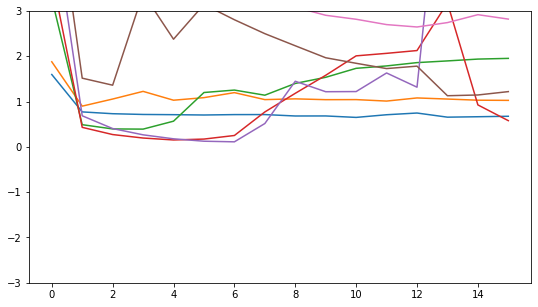

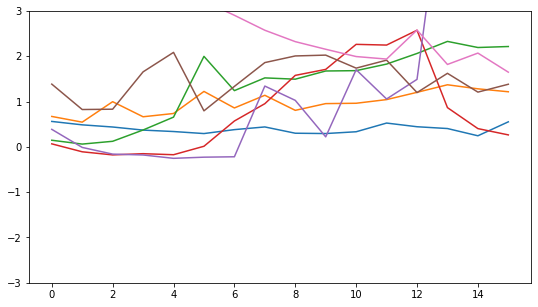

In [65]:
for i in range(2):
    fig = plt.figure()
    axes = plt.gca()
    ymin, ymax = -3, 3
    axes.set_ylim([ymin,ymax])
    for j in range(lossar.shape[0]):
        plt.plot(np.arange(lossar.shape[2]),np.log10(lossar[j,i,:]))
    plt.savefig('plot output/'+\
                    'num_ampl='+str(ampl)+\
                    'bn'+str(bn)+\
                    'bs'+str(batch_size)+\
                    'epochs'+str(num_epochs)+\
                    'net_name=Densenet'+\
                    'lr'+str(0.01)+\
                    'optimizer adam'+\
                    'time'+str(time.time())+\
                '.png', bbox_inches='tight')

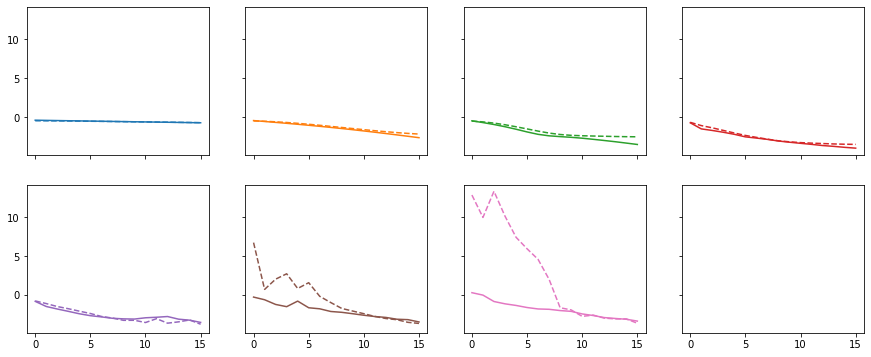

In [64]:
linestyles = ['-', '--']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink']
fig, axs = plt.subplots(2, 4, figsize=(15, 6), sharex=True, sharey=True)
# fig = plt.figure()
# axes = plt.gca()
axs = axs.ravel()
# ymin, ymax = -5, 1
# axs.set_ylim([ymin,ymax])
for j in range(lossar.shape[0]):
    for i in range(2):
        axs[j].plot(np.arange(lossar.shape[2]),np.log10(lossar[j,i,:]),linestyle=linestyles[i],color=colors[j])
    plt.savefig('plot output/'+\
                    'num_ampl='+str(ampl)+\
                    'bn'+str(bn)+\
                    'bs'+str(batch_size)+\
                    'epochs'+str(num_epochs)+\
                    'net_name=Densenet'+\
                    'lr'+str(0.01)+\
                    'optimizer adam'+\
                    'time'+str(time.time())+\
                '.png', bbox_inches='tight')

In [ ]:
# First create some toy data:
x = np.linspace(0, 2*np.pi, 400)
y = np.sin(x**2)

# Create just a figure and only one subplot
fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_title('Simple plot')

# Create two subplots and unpack the output array immediately
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(x, y)
ax1.set_title('Sharing Y axis')
ax2.scatter(x, y)

# Create four polar axes and access them through the returned array
fig, axs = plt.subplots(2, 2, subplot_kw=dict(projection="polar"))
axs[0, 0].plot(x, y)
axs[1, 1].scatter(x, y)

# Share a X axis with each column of subplots
plt.subplots(2, 2, sharex='col')

# Share a Y axis with each row of subplots
plt.subplots(2, 2, sharey='row')

# Share both X and Y axes with all subplots
plt.subplots(2, 2, sharex='all', sharey='all')

# Note that this is the same as
plt.subplots(2, 2, sharex=True, sharey=True)

# Create figure number 10 with a single subplot
# and clears it if it already exists.
fig, ax = plt.subplots(num=10, clear=True)

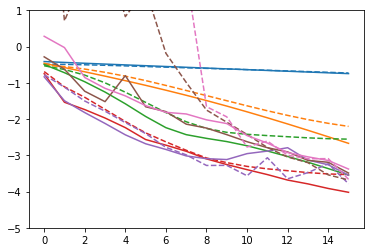

In [41]:
linestyles = ['-', '--']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink']
fig = plt.figure()
axes = plt.gca()
ymin, ymax = -5, 1
axes.set_ylim([ymin,ymax])
for j in range(lossar.shape[0]):
    for i in range(2):
        plt.plot(np.arange(lossar.shape[2]),np.log10(lossar[j,i,:]),linestyle=linestyles[i],color=colors[j])
        plt.savefig('plot output/'+\
                        'num_ampl='+str(ampl)+\
                        'bn'+str(bn)+\
                        'bs'+str(batch_size)+\
                        'epochs'+str(num_epochs)+\
                        'net_name=Densenet'+\
                        'lr'+str(0.01)+\
                        'optimizer adam'+\
                        'time'+str(time.time())+\
                    '.png', bbox_inches='tight')

In [175]:
gt[0]

tensor([116.4052,  -4.5133,  -1.2207,   2.5304,   1.2562,   1.5972,  28.4781,
         -0.3388,  -4.0248], device='cuda:0')

In [171]:
output[0]

array([ 1.68229964e+05, -8.29707898e+02, -1.61415700e+02,  4.12925140e+02,
       -4.65201424e+02, -3.69757145e+02,  3.08982682e+04, -4.62194180e+02,
       -1.92148694e+04])

In [126]:
real_output[0]

array([116.40520943,  -4.51331063,  -1.22070776,   2.53049672,
         1.25615844,   1.59720443,  28.4781262 ,  -0.33878004,
        -4.02484515])

In [140]:
output.shape

(64, 9)

In [144]:
criterion = nn.MSELoss(reduction='mean')

In [145]:
criterion()

MSELoss()

In [149]:

nn.MSELoss((output,real_output),reduction='mean')

C:\Users\v.cherepashkin\Anaconda3\envs\sh\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


MSELoss()

In [94]:
opar[1][:3,:3]

array([[-2.72172054e-05,  1.84768336e-06, -1.18168831e-05],
       [ 1.84768336e-06, -3.43395946e-05,  3.90259151e-06],
       [-1.18168831e-05,  3.90259151e-06, -1.68379114e-05]])

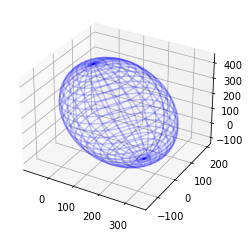

In [105]:
elplot2(opar[0],opar[1][:3,:3])

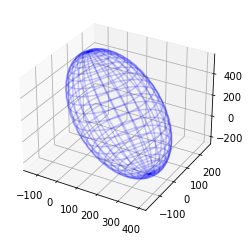

In [106]:
elplot2(ropar[0],ropar[1][:3,:3])

<ipython-input-97-6e214b117730>:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.subplot(2, 2, 1)


ValueError: The Subplot must have been created in the present figure

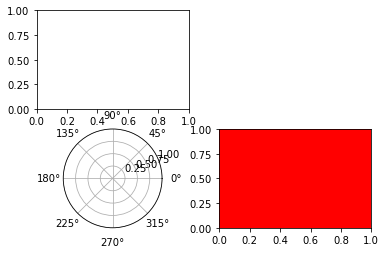

In [97]:
plt.subplot(221)

# equivalent but more general
ax1 = plt.subplot(2, 2, 1)

# add a subplot with no frame
ax2 = plt.subplot(222, frameon=False)

# add a polar subplot
plt.subplot(223, projection='polar')

# add a red subplot that shares the x-axis with ax1
plt.subplot(224, sharex=ax1, facecolor='red')

# delete ax2 from the figure
plt.delaxes(ax2)

# add ax2 to the figure again
plt.subplot(ax2)

# make the first axes "current" again
plt.subplot(221)

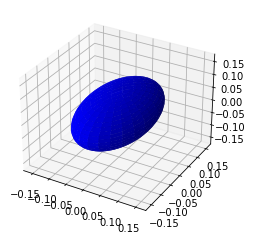

In [74]:
elplot(opar[0])

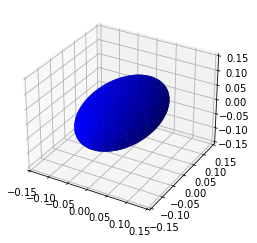

In [76]:
elplot(ropar[0])

## seed before and after supervised learning

Comparison with Model Trained from Scratch
------------------------------------------

Just for fun, lets see how the model learns if we do not use transfer
learning. The performance of finetuning vs. feature extracting depends
largely on the dataset but in general both transfer learning methods
produce favorable results in terms of training time and overall accuracy
versus a model trained from scratch.




In [ ]:
# Initialize the non-pretrained version of the model used for this run
model_names = ["resnet", "alexnet", "vgg", "squeezenet", "densenet"]
scratch_hist = np.zeros([len(model_names),2,num_epochs])
for i, model_name in  enumerate(model_names):
    scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
    scratch_model = scratch_model.to(device)
    scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
    scratch_criterion = nn.MSELoss('mean')
    #scratch_criterion = nn.CrossEntropyLoss()
    _,scratch_hist[i] = train_model(scratch_model, dataloaders_dict, scratch_criterion, \
                                 scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

In [ ]:
scratch_hist.shape

In [ ]:
linestyles = ['-','--']
for i in range(2):
    plt.plot(np.arange(num_epochs),scratch_hist[i,:],color = 'tab:blue',linestyle = linestyles[i],linewidth = 3)
plt.savefig('plot output/'+\
                'num_ampl='+str(ampl)+\
                'bn'+str(bn)+\
                'bs'+str(batch_size)+\
                'epochs'+str(num_epochs)+\
                'net_names'+str(net_names)+\
                'lr'+str(0.001)+\
                'momentum'+str(0.9)+\
                'optimizer SGD'+\
                'scratch'+str(1)+\
                'time'+str(time.time())+\
            '.png', bbox_inches='tight')

In [ ]:
# Plot the training curves of validation accuracy vs. number 
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

Final Thoughts and Where to Go Next
-----------------------------------

Try running some of the other models and see how good the accuracy gets.
Also, notice that feature extracting takes less time because in the
backward pass we do not have to calculate most of the gradients. There
are many places to go from here. You could:

-  Run this code with a harder dataset and see some more benefits of
   transfer learning
-  Using the methods described here, use transfer learning to update a
   different model, perhaps in a new domain (i.e. NLP, audio, etc.)
-  Once you are happy with a model, you can export it as an ONNX model,
   or trace it using the hybrid frontend for more speed and optimization
   opportunities.




## search for the best model

In [ ]:
# Setup the loss fxn
#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss(reduction='mean')
bn = 1
#model_ft = None
num_epochs = 10
net_names = ["resnet", "alexnet", "vgg", "squeezenet", "densenet"]
#["vgg", "squeezenet"]
lossa = np.zeros([len(net_names),2,num_epochs])
#["resnet", "alexnet", "vgg", "squeezenet", "densenet"]
for i, model_name in enumerate(net_names):
# Train and evaluate
    model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
    print(input_size)
    model_ft.to(device)
    model_ft, lossar = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))
    lossa[i] = lossar

In [ ]:
print(scratch_hist.shape)

In [ ]:
fig = plt.figure()
axes = plt.gca()
ymin, ymax = 0, 10
axes.set_ylim([ymin,ymax])
linestyles = ['-', '--', '-.', ':', '-', '--',\
                  '-.', ':', '-', '--', '-.', ':']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
lossa = scratch_hist
for i in range(lossa.shape[0]):
    for j in range(lossa.shape[1]):
        plt.plot(np.arange(num_epochs), \
                 lossa[i,j,:], \
                 color = colors[i], linestyle=linestyles[j], \
                 linewidth=3)
plt.savefig('plot output/'+\
                'num_ampl='+str(ampl)+\
                'bn'+str(bn)+\
                'bs'+str(batch_size)+\
                'epochs'+str(num_epochs)+\
                'net_names'+str(net_names)+\
                'lr'+str(0.001)+\
                'momentum'+str(0.9)+\
                'optimizer SGD'+\
                'time'+str(time.time())+\
            '.png', bbox_inches='tight')

In [ ]:
linestyles = ['-', '--', '-.', ':', '-', '--',\
                  '-.', ':', '-', '--', '-.', ':']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
lossa = scratch_hist
for j in range(lossa.shape[1]):
    fig = plt.figure()
    axes = plt.gca()
    ymin, ymax = 0, 10
    axes.set_ylim([ymin,ymax])
    for i in range(lossa.shape[0]):
        plt.plot(np.arange(num_epochs), \
                 lossa[i,j,:], \
                 color = colors[i], linestyle=linestyles[j], \
                 linewidth=3)
    plt.savefig('plot output/'+\
                    'num_ampl='+str(ampl)+\
                    'bn'+str(bn)+\
                    'bs'+str(batch_size)+\
                    'epochs'+str(num_epochs)+\
                    'net_names'+str(net_names)+\
                    'lr'+str(0.001)+\
                    'momentum'+str(0.9)+\
                    'optimizer SGD'+\
                    'phase'+str(j)+\
                    'time'+str(time.time())+\
                '.png', bbox_inches='tight')

## search for maximum size of the ply file

In [ ]:
cip = []
for root, directories, filenames in os.walk(data_dir): 
    for filename in filenames:
        if filename[-4:] == '.ply':
            cip.append(os.path.join(root,filename))

In [ ]:
len(cip)
cip[0]

In [ ]:
maxsize = 0
sizear = []
i = 0
sumav = 0
for path in cip:
    img = np.genfromtxt(path, skip_header = 7, skip_footer = 1)
    sumav += os.stat(path).st_size/img.shape[0]

    i+=1
    if i == 50:
        break
    
sumav/50

#     sizear.append(img.shape[0])
#     if img.shape[0]>maxsize:
#         maxsize = img.shape[0]
# print(maxsize)

In [ ]:
32.761725985875024

In [ ]:
maxsize = 0
sizear = np.zeros(len(cip))
i = 0
sumav = 0
for i, path in enumerate(cip):
#    img = np.genfromtxt(path, skip_header = 7, skip_footer = 1)
    sizear[i] = os.stat(path).st_size/32.761725985875024
    
#     sizear.append(img.shape[0])
#     if img.shape[0]>maxsize:
#         maxsize = img.shape[0]
# print(maxsize)
plt.plot(np.sort(sizear))

In [ ]:
print(np.max(sizear))